In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dacon-credit/sample_submission.csv
/kaggle/input/dacon-credit/train.csv
/kaggle/input/dacon-credit/test.csv


In [2]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.metrics import accuracy_score,log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import lightgbm as lgb
import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Dacon credit-card analysis

https://dacon.io/competitions/official/235713/overview/description/

In [3]:
SEED = 2021
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# 1. EDA

https://3months.tistory.com/292
## (1) 데이터 불러오기

In [4]:
train_df=pd.read_csv('../input/dacon-credit/train.csv')
test_df=pd.read_csv('../input/dacon-credit/test.csv')
submission = pd.read_csv('../input/dacon-credit/sample_submission.csv')
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)


In [5]:
print("rows and columns in train set : ", train_df.shape)
print("rows and columns in test set : ", test_df.shape)

rows and columns in train set :  (26457, 20)
rows and columns in test set :  (10000, 19)


In [6]:
print(train_df.head(5))

   index gender car reality  child_num  income_total           income_type  \
0      0      F   N       N          0      202500.0  Commercial associate   
1      1      F   N       Y          1      247500.0  Commercial associate   
2      2      M   Y       Y          0      450000.0               Working   
3      3      F   N       Y          0      202500.0  Commercial associate   
4      4      F   Y       Y          0      157500.0         State servant   

                        edu_type     family_type           house_type  \
0               Higher education         Married  Municipal apartment   
1  Secondary / secondary special  Civil marriage    House / apartment   
2               Higher education         Married    House / apartment   
3  Secondary / secondary special         Married    House / apartment   
4               Higher education         Married    House / apartment   

   DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  work_phone  phone  email  \
0      -13899         

## (2) 데이터 변수 설명

- gender(범주) : 성별 
- car(범주) : 차량 소유 여부
- reality(범주) : 부동산 소유 여부
- child_num(범주): 자녀 수
- income_total(수치) : 연간 소득
- income_type(범주) : 소득 분류
    * 'Commercial associate' :상업 제휴
    * 'Working' : 일반 근무
    * 'State servant' : 공무원
    * 'Pensioner' : 연금 수령자
    * 'Student' : 학생
- edu_type(범주) : 교육 수준
    * 'Higher education' : 고등 교육
    * 'Secondary / secondary special' : 중등 교육?
    * 'Incomplete higher' : 고등학교 중퇴
    * 'Lower secondary'  : 중등교육 아래
    * 'Academic degree' : 학위
- family_type(범주): 결혼 여부
    * 'Married' : 결혼함.
    * 'Civil marriage' : 민사적 결혼? 법률혼
    * 'Separated' : 분리된 가족?
    * 'Single / not married' :싱글
    * 'Widow' : 과부
- house_type(범주) : 생활 방식
    * 'Municipal apartment' : 시립 아파트?LH같은거일듯.
    * 'House / apartment' : 주택/ 아파트
    * 'With parents' : 부모님 집
    * 'Co-op apartment' : 전세같음. https://mentor.heykorean.com/web/qa.php?sno=167848
    * 'Rented apartment' : 빌린 아파트?
    * 'Office apartment' : 회사 아파트
- DAYS_BIRTH(수치) : 출생일. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
- DAYS_EMPLOYED(수치) : 업무 시작일. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미. 양수 값은 고용되지 않은 상태를 의미함

- FLAG_MOBIL(범주): 핸드폰 소유 여부
- work_phone(범주): 업무용 전화 소유 여부
- phone(범주): 전화 소유 여부
- email(범주): 이메일 소유 여부
- occyp_type(범주): 직업 유형
- family_size(범주): 가족 규모
- begin_month(수치): 신용카드 발급 월. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미


- credit(범주) : 사용자의 신용카드 대금 연체를 기준으로 한 신용도. 낮을수록 높은 신용의 신용카드 사용자를 의미. 상중하(0,1,2)

https://www.dacon.io/competitions/official/235713/talkboard/402821/

## (3) 결측치 갯수 측정

In [7]:
print('Missing values per columns in train dataset')
for col in train_df.columns:
    temp_col = train_df[col].isnull().sum()
    print(f'{col}: {temp_col}')
print()
print('Missing values per columns in test dataset')
for col in test_df.columns:
    temp_col = test_df[col].isnull().sum()
    print(f'{col}: {temp_col}')

Missing values per columns in train dataset
index: 0
gender: 0
car: 0
reality: 0
child_num: 0
income_total: 0
income_type: 0
edu_type: 0
family_type: 0
house_type: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
FLAG_MOBIL: 0
work_phone: 0
phone: 0
email: 0
occyp_type: 8171
family_size: 0
begin_month: 0
credit: 0

Missing values per columns in test dataset
index: 0
gender: 0
car: 0
reality: 0
child_num: 0
income_total: 0
income_type: 0
edu_type: 0
family_type: 0
house_type: 0
DAYS_BIRTH: 0
DAYS_EMPLOYED: 0
FLAG_MOBIL: 0
work_phone: 0
phone: 0
email: 0
occyp_type: 3152
family_size: 0
begin_month: 0


In [8]:
all_df




,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0,NaN
36453,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0,NaN
36454,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0,NaN
36455,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0,NaN


In [9]:
all_df['occyp_type'] = all_df['occyp_type'].fillna('X')


In [10]:
print(all_df['DAYS_EMPLOYED'])

0        -4709
1        -1540
2        -4434
3        -2092
4        -2105
         ...  
36452    -5434
36453    -1315
36454   -14018
36455    -1085
36456     -187
Name: DAYS_EMPLOYED, Length: 36457, dtype: int64


In [11]:
Employ_list=all_df['DAYS_EMPLOYED'].unique().tolist()
for i in Employ_list:
    if i>=0: print(i)

365243


In [12]:
all_df['DAYS_EMPLOYED']=all_df['DAYS_EMPLOYED'].map(lambda x:0 if (x == 365243) else x)


In [13]:
Employ_list=all_df['DAYS_EMPLOYED'].unique().tolist()
for i in Employ_list:
    if i>=0: print(i)

0


결측치가 존재하는 데이터는 occyp_type.
DAYS_EMPLOYED는 결측치가 없어보이지만 결측치가 365243으로  대체되어있어서 0으로 바꾸어줌.

## (4) 범주형 변수 종류 확인하기



In [14]:
train_df.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [15]:
category_feature=['gender', 'car', 'reality', 'child_num', 
                  'edu_type', 'family_type', 'house_type',
                  'FLAG_MOBIL', 'work_phone', 'phone', 'income_type',
                  'email','occyp_type', 'family_size', 'credit']

numeric_feature=['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']

In [16]:
print(category_feature)
print(numeric_feature)

['gender', 'car', 'reality', 'child_num', 'edu_type', 'family_type', 'house_type', 'FLAG_MOBIL', 'work_phone', 'phone', 'income_type', 'email', 'occyp_type', 'family_size', 'credit']
['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']


In [17]:
for feature in category_feature:
    print("{}'s unique feature: {}".format(feature,train_df[feature].unique()))
    print()
    

gender's unique feature: ['F' 'M']

car's unique feature: ['N' 'Y']

reality's unique feature: ['N' 'Y']

child_num's unique feature: [ 0  1  2  3  4  5 14 19  7]

edu_type's unique feature: ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

family_type's unique feature: ['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']

house_type's unique feature: ['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']

FLAG_MOBIL's unique feature: [1]

work_phone's unique feature: [0 1]

phone's unique feature: [0 1]

income_type's unique feature: ['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']

email's unique feature: [0 1]

occyp_type's unique feature: [nan 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'Realty agents'
 'Security staff' 'Cleaning staff' 'Private serv

https://m.blog.naver.com/PostView.nhn?blogId=cjh226&logNo=221266237919&proxyReferer=https:%2F%2Fwww.google.com%2F

# ENCODING 

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.utils import to_categorical

import statsmodels.api as sm
import matplotlib.pyplot as plt

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
TARGET='credit'

In [21]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

scaler = StandardScaler()


In [22]:
def Simple_lightGBM(x,y):
    X_train, X_valid, y_train, y_valid = train_test_split(x,y,test_size=0.25, random_state=21)
    lgbm_model=lgb.LGBMClassifier(objective='multiclass').fit(X_train, y_train)
    y_pred=lgbm_model.predict_proba(X_valid)

    print(f"log_loss: {log_loss(to_categorical(y_valid), y_pred)}")
    lgb.plot_importance(lgbm_model)


In [23]:
def make_temp(label_cols, numerical_cols,rf_pick=0):
    
    label_encoded_df = all_df[label_cols].apply(label_encoder)
    numerical_df = pd.DataFrame(scaler.fit_transform(all_df[numerical_cols]), columns=numerical_cols)
    target_df = all_df[TARGET]


    temp = pd.concat([numerical_df, label_encoded_df, target_df], axis=1)
    
    
    train = temp.iloc[:26457, :]#0개~100000개
    test = temp.iloc[26457:, :] #100000개~ 
    #iloc은 정수형 인덱싱
    test = test.drop(TARGET, axis=1) #test에서 종속변수를 드랍한다. 
    y= train.loc[:,TARGET]
    X= train.drop(TARGET,axis=1)

    Simple_lightGBM(X,y)
    
    if rf_pick==1:
        X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=21)
        rf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
        cross_val_score(rf, X_train, y_train, cv=3)
        rf.score(X_valid, y_valid)
        print(classification_report(y_valid, rf.predict(X_valid)))

        feature_importance_rf = pd.DataFrame(zip(X.columns.values, rf.feature_importances_))
        feature_importance_rf.columns = ['feature', 'importance']
        feature_importance_rf.sort_values("importance", ascending=False, inplace=True)
        print(feature_importance_rf)
        
    
    return temp
    

In [24]:
all_df.dtypes

index              int64
gender            object
car               object
reality           object
child_num          int64
income_total     float64
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
FLAG_MOBIL         int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit           float64
dtype: object

## 임시 인코딩
변수의 설명력을 확인하기 위해 문자열 전부 라벨인코딩 진행


log_loss: 0.7464494123805511
              precision    recall  f1-score   support

         0.0       0.40      0.27      0.32       795
         1.0       0.56      0.49      0.52      1555
         2.0       0.76      0.84      0.80      4265

    accuracy                           0.69      6615
   macro avg       0.57      0.53      0.55      6615
weighted avg       0.67      0.69      0.68      6615

          feature  importance
6     begin_month    0.344942
3      DAYS_BIRTH    0.152799
5   DAYS_EMPLOYED    0.113532
0    income_total    0.110203
17     occyp_type    0.055949
11    family_type    0.026339
10       edu_type    0.022688
2     family_size    0.021754
15    income_type    0.020361
14          phone    0.019776
7          gender    0.018864
9         reality    0.017535
8             car    0.016567
13     work_phone    0.016333
12     house_type    0.015927
1       child_num    0.015562
16          email    0.010868
4      FLAG_MOBIL    0.000000


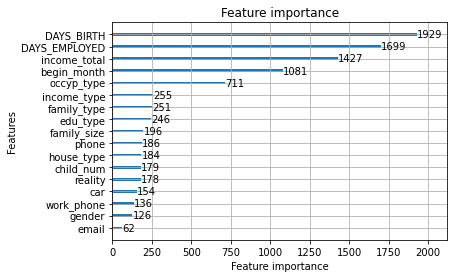

In [25]:
label_cols = ['gender', 'car', 'reality',  
                  'edu_type', 'family_type', 'house_type',
                   'work_phone', 'phone', 'income_type',
                  'email','occyp_type', ]
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total','child_num','family_size', 'DAYS_BIRTH','FLAG_MOBIL', 'DAYS_EMPLOYED', 'begin_month']

df_1=make_temp(label_cols, numerical_cols,1)

In [26]:
"""
var=train.columns[:].tolist()
var.remove(TARGET)
pval = pd.Series(index=var)
adjusted_r = pd.Series(index=var)
y=train[TARGET]

#adjusted_r=[]
steps=[]
step=0
for i in var: 
    X=train[i]
    X=sm.add_constant(X)
    model=sm.OLS(y,X).fit()
    pval[i]=model.pvalues[i]
    #print(model.rsquared_adj)
    adjusted_r[i]=model.rsquared_adj
    #print()
    

print(adjusted_r)
print(pval)
"""


'\nvar=train.columns[:].tolist()\nvar.remove(TARGET)\npval = pd.Series(index=var)\nadjusted_r = pd.Series(index=var)\ny=train[TARGET]\n\n#adjusted_r=[]\nsteps=[]\nstep=0\nfor i in var: \n    X=train[i]\n    X=sm.add_constant(X)\n    model=sm.OLS(y,X).fit()\n    pval[i]=model.pvalues[i]\n    #print(model.rsquared_adj)\n    adjusted_r[i]=model.rsquared_adj\n    #print()\n    \n\nprint(adjusted_r)\nprint(pval)\n'

In [27]:
"""
temp_index=X_train.columns.tolist()
print(temp_index)
lr_score = pd.Series(index=temp_index)
lr_coef = pd.Series(index=temp_index,dtype=object)
print(y_train)
for i in temp_index:
    lr_X = X_train.loc[:,[i]]
    lr_X_val=X_valid.loc[:,[i]]
    #print(lr_X_val)
    model=LogisticRegression( multi_class='multinomial', solver='lbfgs').fit(lr_X, y_train)
    lr_score[i]=model.score(lr_X, y_train)
    #print("lr_score:", lr_score)
    # print(model.score(lr_X_val,y_valid))
    lr_coef[i]=model.coef_
    

    
print(lr_score)
print(lr_coef)

# model=LogisticRegression(random_state=0).fit(X_train,y_train)
# print(model.score(X_train,y_train))    

"""


'\ntemp_index=X_train.columns.tolist()\nprint(temp_index)\nlr_score = pd.Series(index=temp_index)\nlr_coef = pd.Series(index=temp_index,dtype=object)\nprint(y_train)\nfor i in temp_index:\n    lr_X = X_train.loc[:,[i]]\n    lr_X_val=X_valid.loc[:,[i]]\n    #print(lr_X_val)\n    model=LogisticRegression( multi_class=\'multinomial\', solver=\'lbfgs\').fit(lr_X, y_train)\n    lr_score[i]=model.score(lr_X, y_train)\n    #print("lr_score:", lr_score)\n    # print(model.score(lr_X_val,y_valid))\n    lr_coef[i]=model.coef_\n    \n\n    \nprint(lr_score)\nprint(lr_coef)\n\n# model=LogisticRegression(random_state=0).fit(X_train,y_train)\n# print(model.score(X_train,y_train))    \n\n'

In [28]:
"""
log_rg = LogisticRegression().fit(X_train, y_train)
cross_val_score(log_rg, X_train, y_train, cv=5)
log_rg.score(X_valid, y_valid)
print(classification_report(y_valid, log_rg.predict(X_valid)))


feature_importance_lr = pd.DataFrame(zip(X.columns.values, log_rg.coef_.ravel()))
#feature_score=pd.DataFrame(zip(X.columns.values, log_rg.score(X_valid, y_valid)))
feature_importance_lr.columns = ['feature', 'coef']
feature_importance_lr.sort_values("coef", ascending=False, inplace=True)
print(feature_importance_lr)
"""

'\nlog_rg = LogisticRegression().fit(X_train, y_train)\ncross_val_score(log_rg, X_train, y_train, cv=5)\nlog_rg.score(X_valid, y_valid)\nprint(classification_report(y_valid, log_rg.predict(X_valid)))\n\n\nfeature_importance_lr = pd.DataFrame(zip(X.columns.values, log_rg.coef_.ravel()))\n#feature_score=pd.DataFrame(zip(X.columns.values, log_rg.score(X_valid, y_valid)))\nfeature_importance_lr.columns = [\'feature\', \'coef\']\nfeature_importance_lr.sort_values("coef", ascending=False, inplace=True)\nprint(feature_importance_lr)\n'

### 변수 삭제

log_loss: 0.7604071013319379


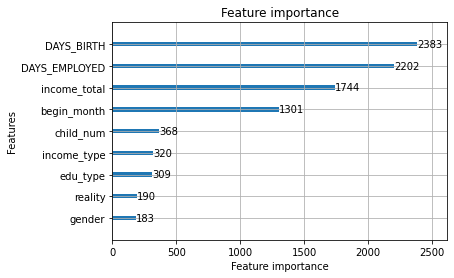

In [29]:
label_cols = ['income_type','edu_type','child_num','gender','reality']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
df_2=make_temp(label_cols,numerical_cols)

### 전처리

In [30]:
#나이 전처리
Age=np.abs(all_df['DAYS_BIRTH'])
Age=np.round(Age/365)
all_df['DAYS_BIRTH']=Age
all_df['DAYS_BIRTH']

# 고용일자 전처리
Year_Employ=np.abs(all_df['DAYS_EMPLOYED'])
Year_Employ=np.ceil(Year_Employ/365)
all_df['DAYS_EMPLOYED']=Year_Employ

# 아이 유무 전처리
all_df['child_num']=all_df['child_num'].map(lambda x:1 if (x >0) else 0)

# 가격 log 취해서 폭 줄여주기
all_df['income_total'] = np.log1p(all_df['income_total'])

# 카드 발급일 전처리
month=np.abs(all_df['begin_month'])
all_df['begin_month']=month




### 데이터 전처리 후 encoding

log_loss: 0.768624328468341


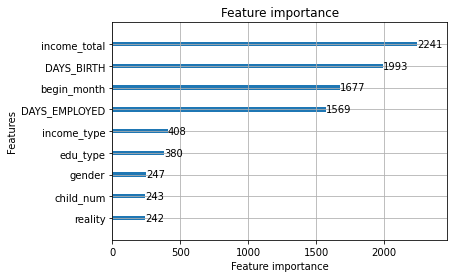

In [31]:
label_cols = ['income_type','edu_type','child_num','gender','reality']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
df_3=make_temp(label_cols,numerical_cols)

## FAMILY SIZE 추가

In [32]:
all_df

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,12.218500,Commercial associate,Higher education,Married,Municipal apartment,38.0,13.0,1,0,0,0,X,2.0,6.0,1.0
1,1,F,N,Y,1,12.419170,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,31.0,5.0,1,0,0,1,Laborers,3.0,5.0,1.0
2,2,M,Y,Y,0,13.017005,Working,Higher education,Married,House / apartment,52.0,13.0,1,0,1,0,Managers,2.0,22.0,2.0
3,3,F,N,Y,0,12.218500,Commercial associate,Secondary / secondary special,Married,House / apartment,41.0,6.0,1,0,1,0,Sales staff,2.0,37.0,0.0
4,4,F,Y,Y,0,11.967187,State servant,Higher education,Married,House / apartment,41.0,6.0,1,0,0,0,Managers,2.0,26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,36452,F,Y,Y,0,12.218500,Working,Incomplete higher,Married,House / apartment,51.0,15.0,1,1,1,0,Accountants,2.0,19.0,NaN
36453,36453,M,Y,Y,0,12.218500,Working,Secondary / secondary special,Civil marriage,House / apartment,30.0,4.0,1,1,0,0,Laborers,2.0,34.0,NaN
36454,36454,F,N,Y,0,12.586223,Working,Secondary / secondary special,Married,House / apartment,58.0,39.0,1,0,0,0,Medicine staff,2.0,55.0,NaN
36455,36455,F,Y,N,0,12.100718,Commercial associate,Secondary / secondary special,Married,House / apartment,45.0,3.0,1,0,1,0,X,2.0,33.0,NaN


log_loss: 0.7654781934556252


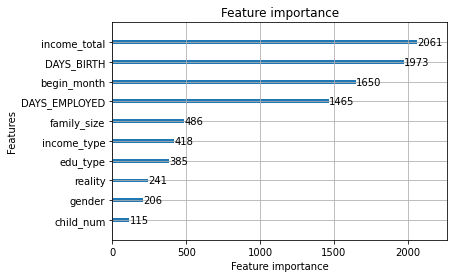

In [33]:
label_cols = ['income_type','edu_type','child_num','gender','reality']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month','family_size']
df_4=make_temp(label_cols,numerical_cols)

log_loss: 0.7654685258063153


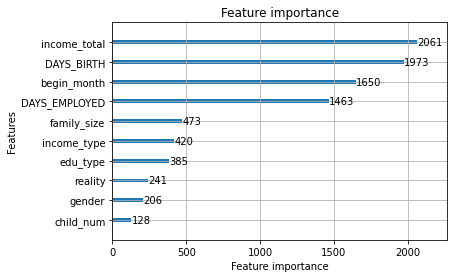

In [34]:
label_cols = ['income_type','edu_type','child_num','gender','reality', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month','family_size']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',]

df_5=make_temp(label_cols,numerical_cols)



log_loss: 0.7688205488926725


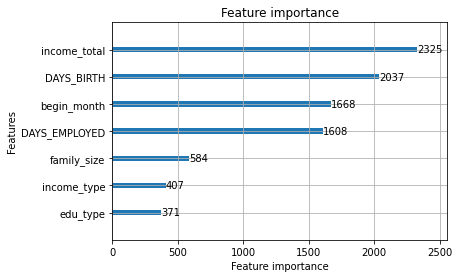

In [35]:
label_cols = ['income_type','edu_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month','family_size']
#onehot_cols = ['gender','car','reality',]
numerical_cols =['income_total',]

df_6=make_temp(label_cols,numerical_cols)

## 불균형 데이터 처리 


In [36]:

import warnings
warnings.filterwarnings("ignore")

In [37]:

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

In [38]:
def Data_imbalnce(temp):
    index_imbalnce=['SMOTE','TomekLinks','SMOTEENN','SMOTETomek']
    list_logloss=pd.Series(index=index_imbalnce)
    train = temp.iloc[:26457, :]#0개~100000개
    test = temp.iloc[26457:, :] #100000개~ 
    #iloc은 정수형 인덱싱
    test = test.drop(TARGET, axis=1) #test에서 종속변수를 드랍한다. 
    y= train.loc[:,TARGET]
    X= train.drop(TARGET,axis=1)
    
    #smote
    X_samp, y_samp = SMOTE(random_state=4).fit_resample(X, y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)
    
    lgbm_model=lgb.LGBMClassifier(objective='multiclass').fit(X_train, y_train)
    y_pred=lgbm_model.predict_proba(X_valid)
    list_logloss['SMOTE']=log_loss(to_categorical(y_valid), y_pred)
    
    #토맥
    X_samp, y_samp = TomekLinks().fit_resample(X, y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)
    
    lgbm_model=lgb.LGBMClassifier(objective='multiclass').fit(X_train, y_train)
    y_pred=lgbm_model.predict_proba(X_valid)
    list_logloss['TomekLinks']=log_loss(to_categorical(y_valid), y_pred)
    
    # 스모틴
    X_samp, y_samp = SMOTEENN(random_state=4).fit_resample(X, y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)
    
    lgbm_model=lgb.LGBMClassifier(objective='multiclass').fit(X_train, y_train)
    y_pred=lgbm_model.predict_proba(X_valid)
    list_logloss['SMOTEENN']=log_loss(to_categorical(y_valid), y_pred)
    
    #스모토멕
    X_samp, y_samp = SMOTETomek(random_state=4).fit_resample(X, y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp,test_size=0.25, random_state=21)
    
    lgbm_model=lgb.LGBMClassifier(objective='multiclass').fit(X_train, y_train)
    y_pred=lgbm_model.predict_proba(X_valid)
    list_logloss['SMOTETomek']=log_loss(to_categorical(y_valid), y_pred)
    
    return list_logloss
    
    

In [39]:
temp_imbal=Data_imbalnce(df_1) #변수 다넣은거
print(temp_imbal)

SMOTE         0.731024
TomekLinks    0.720121
SMOTEENN      0.606737
SMOTETomek    0.725582
dtype: float64


In [40]:
df2_imbal=Data_imbalnce(df_2) #변수 삭제
print(df2_imbal)
    

SMOTE         0.754767
TomekLinks    0.739461
SMOTEENN      0.657920
SMOTETomek    0.750242
dtype: float64
